# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import torch.optim as optim

is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [3]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone'
Hypers.Config.data_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\data'
Hypers.Config.model_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\model'
Hypers.Config.log_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\log'


In [4]:
suffix = "US_balanced_std"

In [5]:
# Optional: Split data into train and test
# You have to run this cell if you changed your feature,rating dataset
path = 'output/data_US_std.pkl'
# merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "data_US.pkl"))
merged_dict = utils.load_pickle(path)
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=False, suffix=suffix)
print(len(train_dict), len(test_dict))

430 128


# LSTM

In [5]:
import LSTMDataset
importlib.reload(LSTMDataset)
import LSTMModel
importlib.reload(LSTMModel)

model_type = "Lstm"

In [6]:
train_dict = utils.load_pickle('output/train_US_std.pkl')
test_dict = utils.load_pickle('output/test_US_std.pkl')
print(f"{len(train_dict)}", f"{len(test_dict)}")

555 158


In [7]:
# train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict_RetInd_4.pkl"))
# test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict_RetInd_4.pkl"))
# print(f"{len(train_dict)}", f"{len(test_dict)}")

# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = LSTMModel.LSTMModel(input_size=99,
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_seq_len=2


In [8]:
model

LSTMModel(
  (lstm): LSTM(99, 32, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

Vaild Epoch 499: 100%|██████████| 500/500 [03:19<00:00,  2.51it/s, Loss: 1.858] 


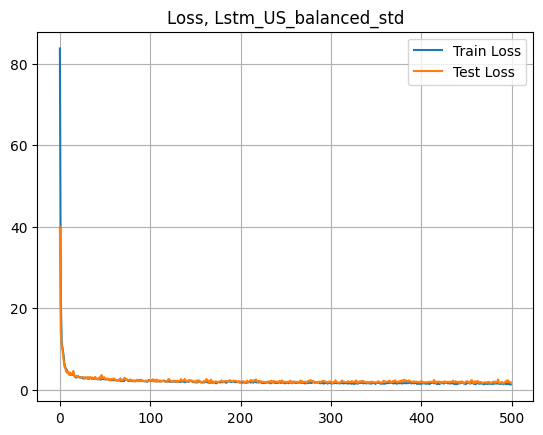

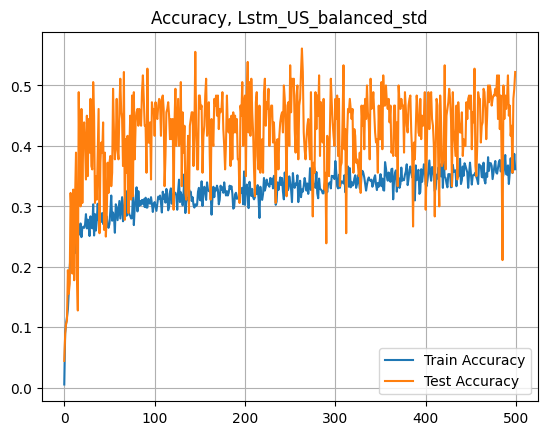

In [9]:
train_set, test_set = LSTMDataset.LSTMDataset(train_dict), LSTMDataset.LSTMDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy, identifier=f"{model_type}_{suffix}")

In [ ]:
utils.plot_graph(trainer.train_loss_history, trainer.train_acccuracy_history, trainer.test_loss_history, trainer.test_acccuracy_history)

In [10]:
for batch in train_loader:
  print(batch[0].shape, batch[1].shape, batch[2].shape)
  break

torch.Size([8, 1, 99]) torch.Size([8, 1]) torch.Size([8, 1])


# Regression

In [6]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

model_type = "Regr"

In [7]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")

len(train_dict)=595 len(test_dict)=171


In [8]:
input_size = len(train_dict["AMZN"]["2010Q4"][0])
print(f"{input_size=}")

input_size=192


Vaild Epoch 499: 100%|██████████| 500/500 [15:59<00:00,  1.92s/it, Loss: 6.762]  


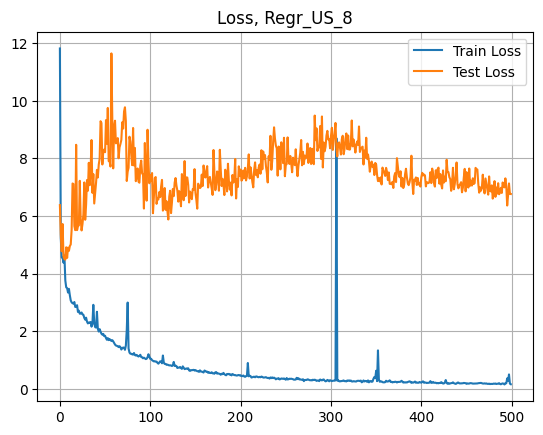

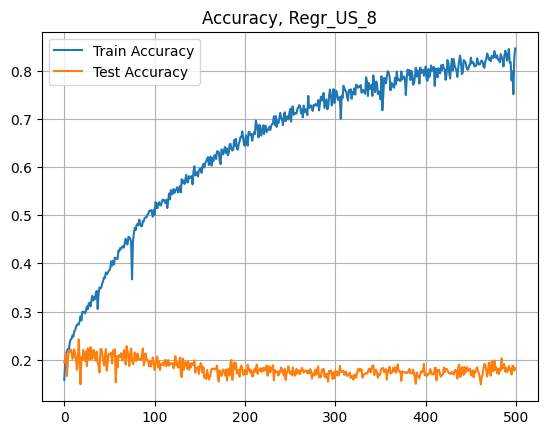

In [9]:
train_set = RegressionDataset.RegressionDataset(train_dict)
valid_set = RegressionDataset.RegressionDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)

model = RegressionModel.RegressionModel(input_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader, 
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Conv1d

In [10]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

In [11]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=595 len(test_dict)=171
US_8


Vaild Epoch 499: 100%|██████████| 500/500 [16:46<00:00,  2.01s/it, Loss: 13.230] 


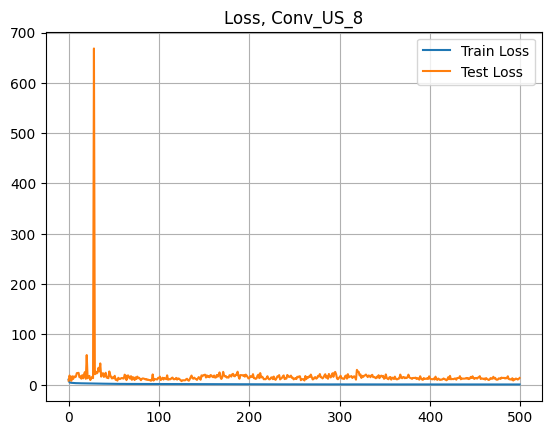

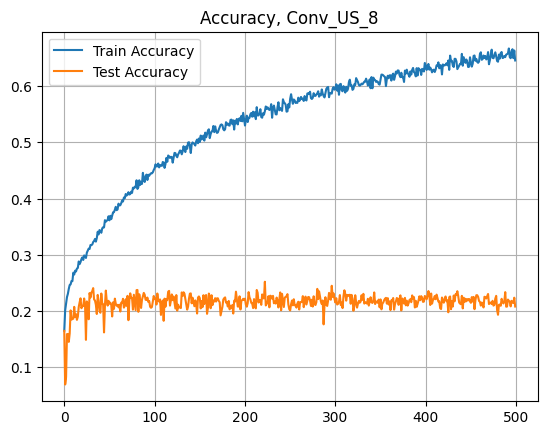

In [12]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=8)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=8)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=24)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader, 
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [11]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from 'd:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\Inferencer.py'>

In [12]:
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [13]:
len(turths)

180

In [14]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([ 8.,  8., 13., 12., 12., 12.,  6., 11., 12., 12.], device='cuda:0')
tensor([ 7.,  8., 12., 12., 11., 12.,  5., 11., 12., 12.], device='cuda:0')


In [15]:
print(diff_counter)

Counter({0.0: 94, 1.0: 61, 2.0: 11, 3.0: 7, 4.0: 3, 6.0: 3, 5.0: 1})


In [16]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=180


In [17]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.5222222222222223,
 0.8611111111111112,
 0.9222222222222223,
 0.9611111111111111,
 0.9777777777777777]

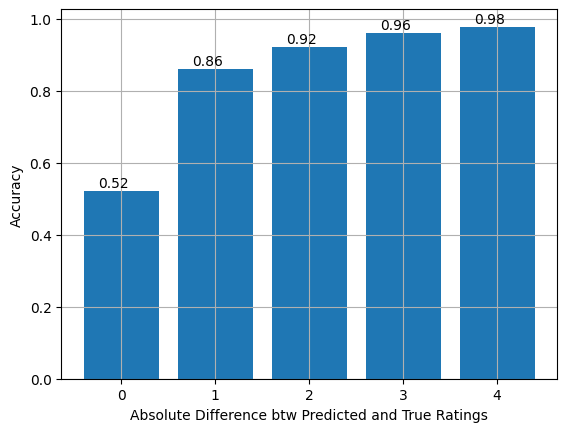

In [18]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [20]:
for batch in test_loader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([8, 1, 99]) torch.Size([8, 1]) torch.Size([8, 1])


In [21]:
train_dict 1200

{'TXN': {'2010Q4': (tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00,
            4.5363e-01,  6.9059e-02,  1.9870e-01,  3.8567e-01,  7.5842e-02,
            3.9450e-01, -1.1808e-02, -1.8278e-01, -1.1916e-01,  1.0135e+00,
            8.6235e-02,  3.3152e-01,  6.0671e-01,  5.6411e-01,  2.6897e-02,
            2.1557e-02,  1.7830e-02,  5.7216e-03, -2.2525e-02, -5.1296e-03,
            3.7085e-02,  2.1883e-03, -5.6897e-02,  2.1801e+02,  5.0000e+00,
            4.9438e-01,  7.7121e-02,  2.1789e-01,  4.3971e-01,  9.8353e-02,
            4.3041e-01,  3.4641e-02, -1.8512e-01, -1.0063e-01,  1.1511e+00,
            1.0570e-01,  3.7238e-01,  6.2513e-01,  6.0636e-01,  2.6725e

In [22]:
test_dict

{'MHK': {'2016Q4': (tensor([ 1.3304e-01,  1.1226e-01,  1.2465e-01, -1.9603e-01,  8.7168e-02,
            5.3957e-01,  2.6467e-01, -8.5054e-02,  6.1085e-02,  1.0060e-01,
            8.4823e-02,  1.0985e-01,  1.9750e-01,  1.5655e-01,  5.9388e-03,
            1.9530e-02, -9.5762e-02, -9.3216e-02, -8.0210e-02,  1.5240e-03,
            2.6641e-02, -5.1572e-03, -5.8981e-02,  2.3692e+02,  8.0000e+00,
            1.3891e-01,  1.1072e-01,  1.2546e-01, -1.9240e-01,  9.2456e-02,
            5.4345e-01,  2.3464e-01, -8.6631e-02,  4.7167e-02,  2.2841e-01,
            8.6581e-02,  1.3301e-01,  2.1788e-01,  1.6613e-01,  8.2228e-03,
            1.9983e-02, -9.2663e-02, -9.1406e-02, -7.9966e-02,  8.0386e-04,
            2.9812e-02, -2.8815e-03, -5.8840e-02,  2.3926e+02,  8.0000e+00,
            1.4579e-01,  1.1350e-01,  1.2972e-01, -1.9239e-01,  9.1521e-02,
            5.4972e-01,  2.1197e-01, -9.0250e-02,  3.5138e-02,  2.5086e-01,
            9.5326e-02,  1.3030e-01,  2.4343e-01,  1.4967e-01,  8.0199e